In [1]:
import ncar_jobqueue

In [2]:
cluster = ncar_jobqueue.NCARCluster(
#    cores=9,  # The number of cores you want
    memory='15GB',  # Amount of memory
#    processes=9,  # How many processes
    walltime='04:30:00',  # Amount of wall time
    project="ncgd0011",  #Project id
)

cluster.scale(6)


/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/dask_jobqueue/core.py:251: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/dask_jobqueue/core.py:270: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glad

In [3]:
%matplotlib inline
%load_ext autoreload
%load_ext watermark

from etpac import annotate_stats
import dask
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


import numpy as np
#import pandas as pd
import xarray as xr
#import xgcm
import cartopy.crs as cr
from cartopy import feature as cf

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 180

xr.set_options(keep_attrs=True, display_style="html")

%watermark -iv

matplotlib   : 3.6.0
numpy        : 1.23.3
dask         : 2022.9.1
distributed  : 2022.9.1
ncar_jobqueue: 2021.4.14
sys          : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:35:26) [GCC 10.4.0]
xarray       : 2022.9.0
json         : 2.0.9
cartopy      : 0.21.0



In [4]:
client = distributed.Client(cluster)
client

<Client: 'tcp://10.12.206.62:41733' processes=2 threads=4, memory=27.94 GiB>

In [5]:
files1 = '/glade/scratch/pmora/Wek_month_F.nc'

In [6]:
DS1 = xr.open_mfdataset(
    files1,
    compat="override",
    data_vars="minimal",
    coords="minimal",
    parallel=True,
    concat_dim="time",
    combine="nested",
)
#[["so", "thetao", "uo", "vo", "wo"]]


In [7]:
DS1

<xarray.Dataset>
Dimensions:  (yh: 74, xh: 140, month: 12)
Coordinates:
  * yh       (yh) float64 8.025 8.075 8.125 8.175 ... 11.52 11.57 11.62 11.68
  * xh       (xh) float64 270.0 270.1 270.1 270.2 ... 276.8 276.9 276.9 277.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Wek      (month, yh, xh) float32 dask.array<chunksize=(12, 74, 140), meta=np.ndarray>
    Wek_u    (month, yh, xh) float32 dask.array<chunksize=(12, 74, 140), meta=np.ndarray>
    Wek_v    (month, yh, xh) float32 dask.array<chunksize=(12, 74, 140), meta=np.ndarray>

In [8]:
geometry_file = '/glade/scratch/bachman/ETP.012_tides3/run/ocean_geometry.nc'
dsg = xr.open_dataset(geometry_file)
dsg=dsg.rename({'lonh':'xh','lonq':'xq','lath':'yh','latq':'yq'})

In [9]:
sclfac = 86400.
rho0 = 1.0e3
lonbeg = 270
lonend = 277
latbeg = 8
latend = 11.7

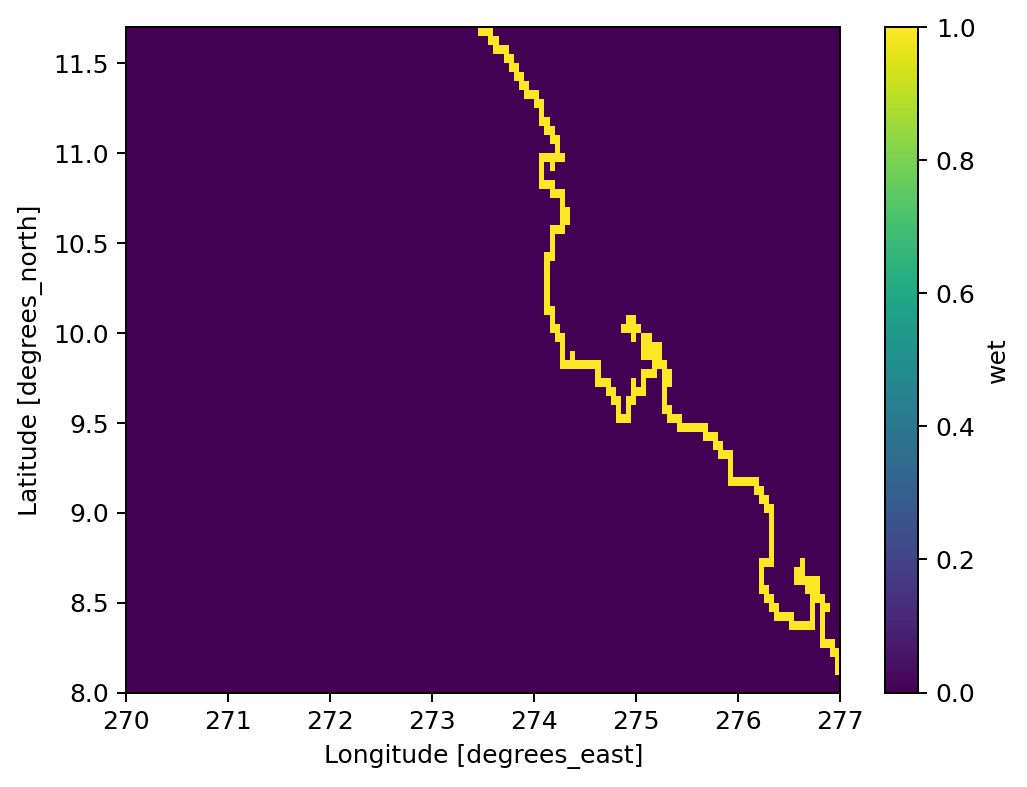

In [10]:
wet = dsg['wet'].astype('int')
land = 1 - wet
e = land.shift(xh=-1,fill_value=1)
w = land.shift(xh=1,fill_value=0)
n = land.shift(yh=-1,fill_value=0)
s = land.shift(yh=1,fill_value=0)
ne = n.shift(xh=-1,fill_value=1)
nw = n.shift(xh=1,fill_value=0)
se = s.shift(xh=-1,fill_value=0)
sw = s.shift(xh=1,fill_value=0)
neighbors = n + s + e + w + ne + nw + se + sw
coast = neighbors*dsg['wet']
coast = xr.where(coast >= 1,1,0)
ocean = dsg['wet'] - coast
coast.sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

In [11]:
coast

<xarray.DataArray 'wet' (yh: 900, xh: 1000)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * yh       (yh) float64 -14.97 -14.93 -14.88 -14.82 ... 29.88 29.92 29.98
  * xh       (xh) float64 235.0 235.1 235.1 235.2 ... 284.8 284.9 284.9 285.0

In [12]:
Ep1 = (DS1.Wek)*86400
Ep1

<xarray.DataArray 'Wek' (month: 12, yh: 74, xh: 140)>
dask.array<mul, shape=(12, 74, 140), dtype=float64, chunksize=(12, 74, 140), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 8.025 8.075 8.125 8.175 ... 11.52 11.57 11.62 11.68
  * xh       (xh) float64 270.0 270.1 270.1 270.2 ... 276.8 276.9 276.9 277.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  Total Ekman upwelling
    units:      m/s

In [13]:
#Ep2 = Ep.sel(xh=np.arange(272,277,0.05), yh=np.arange(8,12,0.05), method="nearest")
Ep2 = Ep1.sel(xh=slice(273, 275), yh=slice(9.5, 11.5))              
#Ep2

In [14]:
CoastUp = (Ep2*coast)
CoastUp  = CoastUp .where(CoastUp  != 0.)
EPocean = (Ep2*ocean)
EPocean = EPocean.where(EPocean != 0.)
CoastMean = (Ep2*coast).mean('month')
CoastMean = CoastMean.where(CoastMean != 0.)
EPoceanMean = (Ep2*ocean).mean('month')
EPoceanMean = EPoceanMean.where(EPoceanMean != 0.)

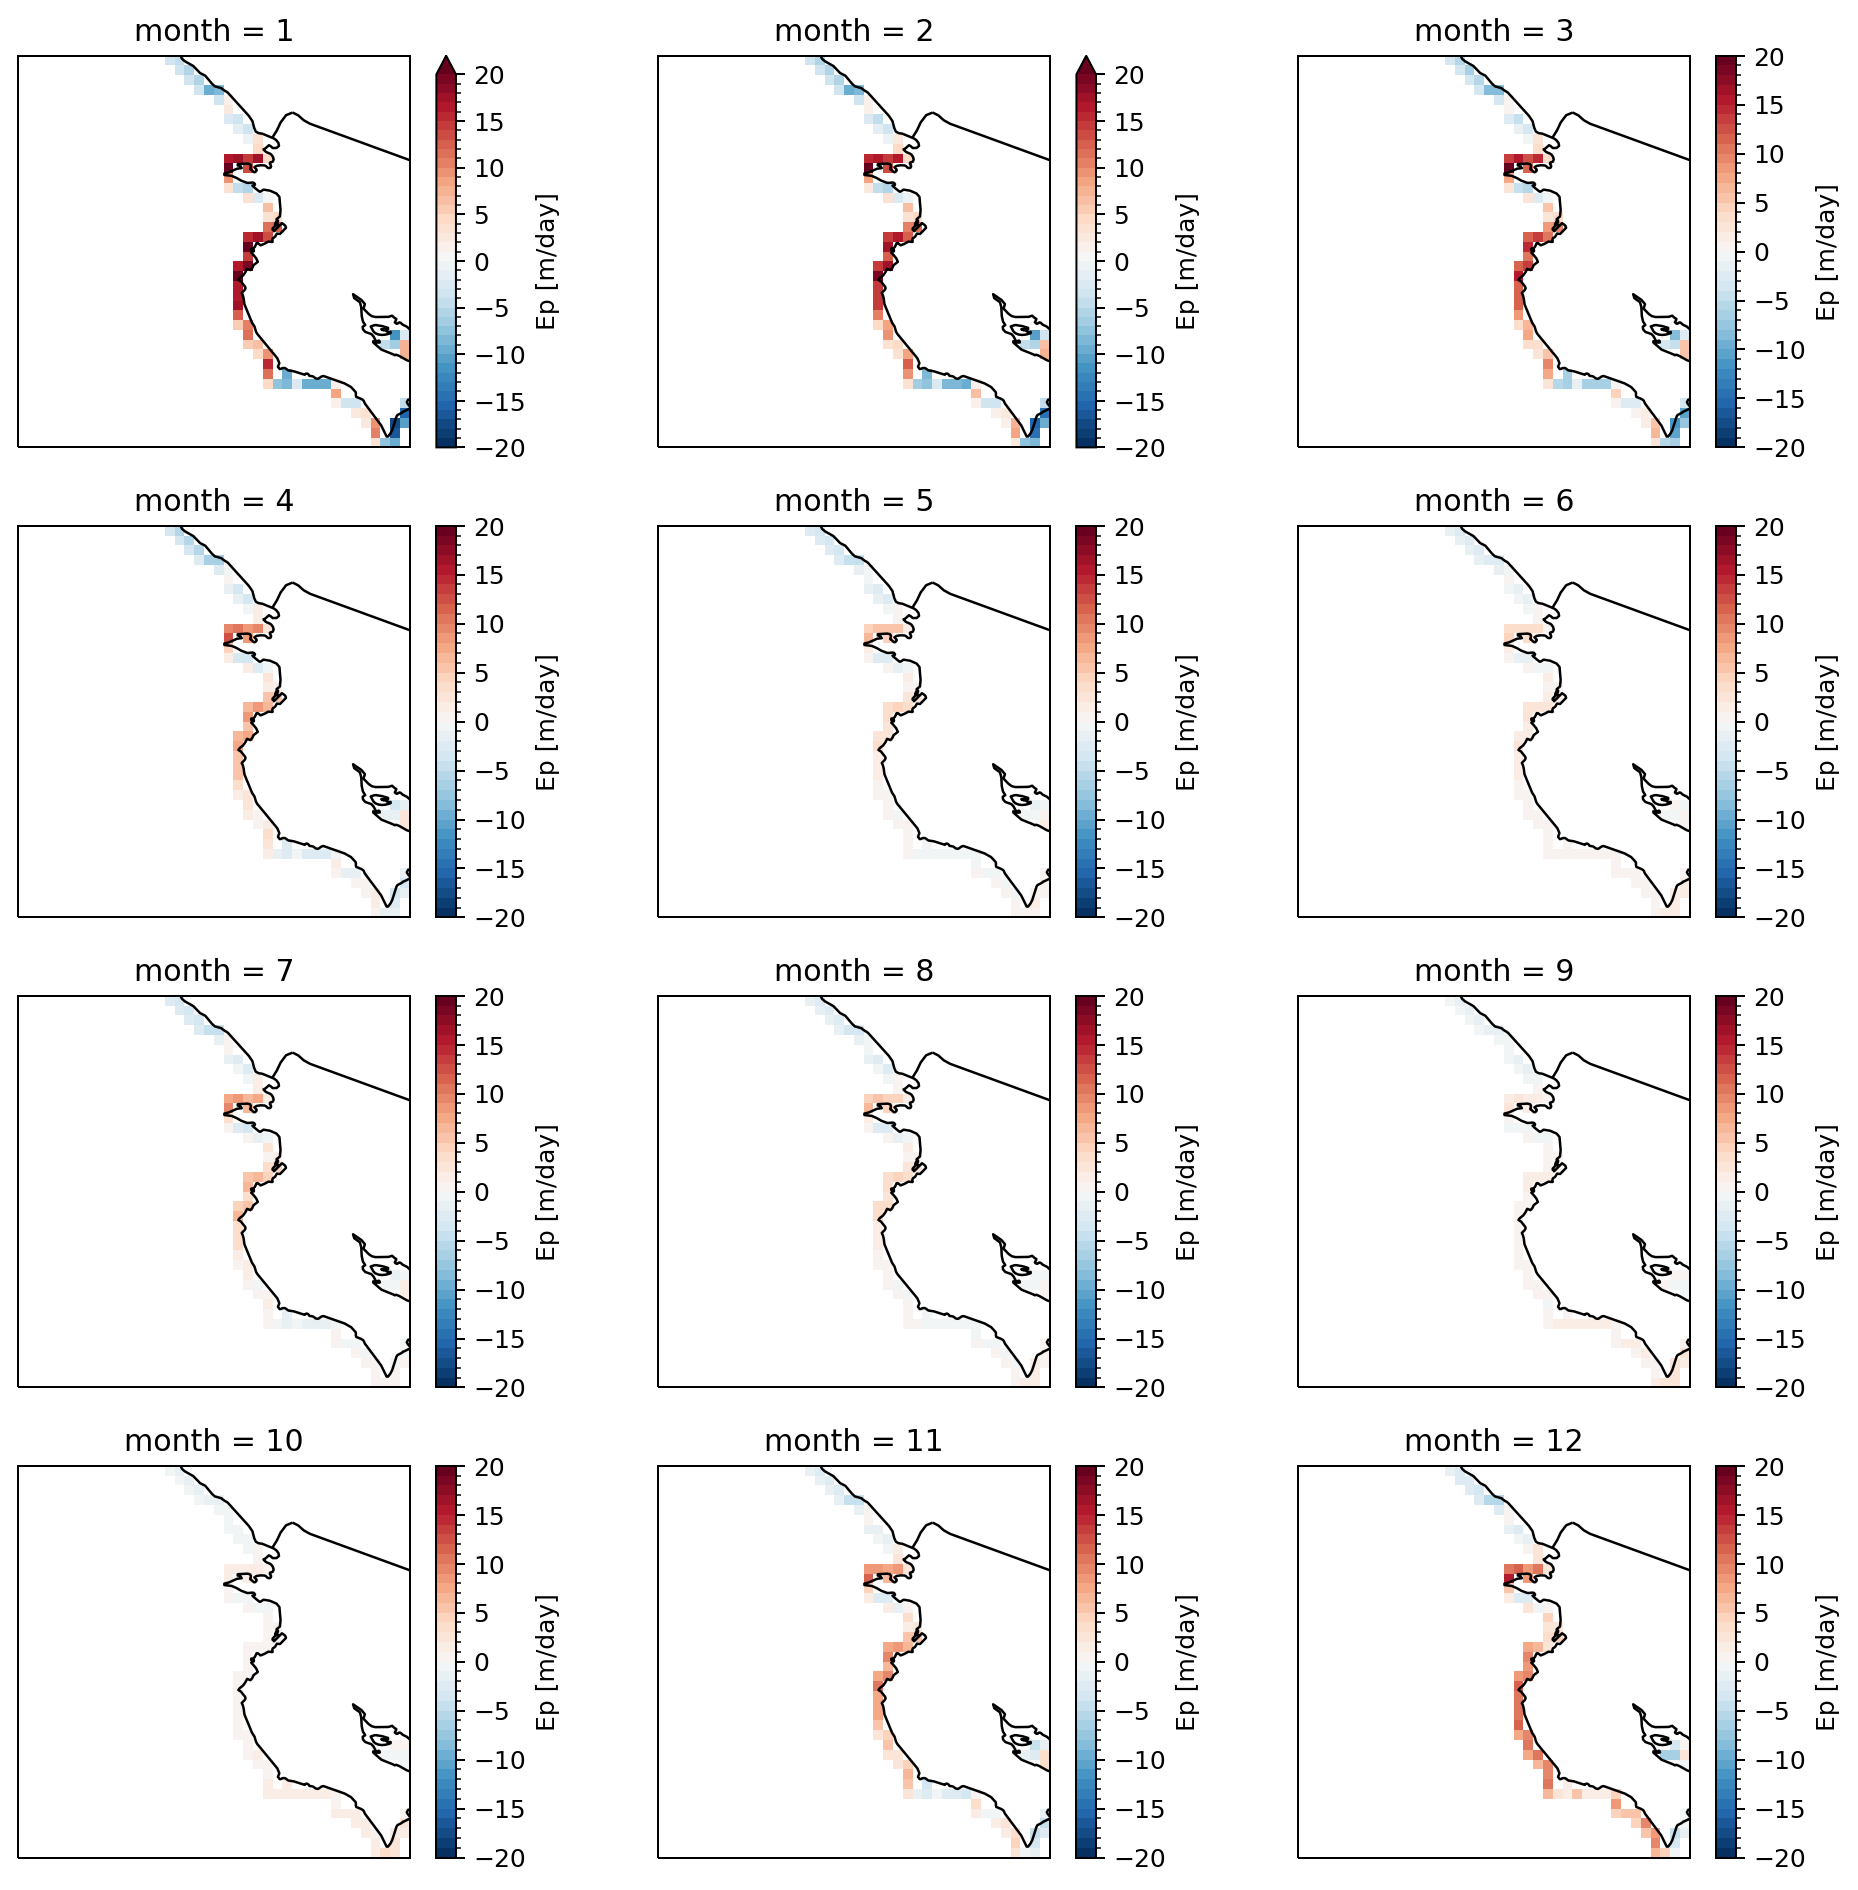

In [17]:
count = 0
fig=plt.figure(figsize=(13,13))
for mes in CoastUp.month:
             count+=1
             ax=fig.add_subplot(4,3,count,projection=cr.PlateCarree())
             #Ep2[Ep2.month==mes].plot(vmin=-4, vmax=4, cmap="coolwarm_r", cbar_kwargs={"label": "w [m/day]"}, levels=np.arange(-4,4.5,0.5))
             (CoastUp[CoastUp.month==mes]).plot(vmin=-20, vmax=20, cmap="RdBu_r", cbar_kwargs={"label": "Ep [m/day]"}, levels=np.arange(-20,21,1))
#             annotate_stats(plt.gca(), Ep2[Ep2.month==mes], x=0.3, y=0.4)
             ax.coastlines(resolution='10m')
             ax.add_feature(cf.BORDERS)
             ax.set_extent([-87, -85, 9.5,11.5])

/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


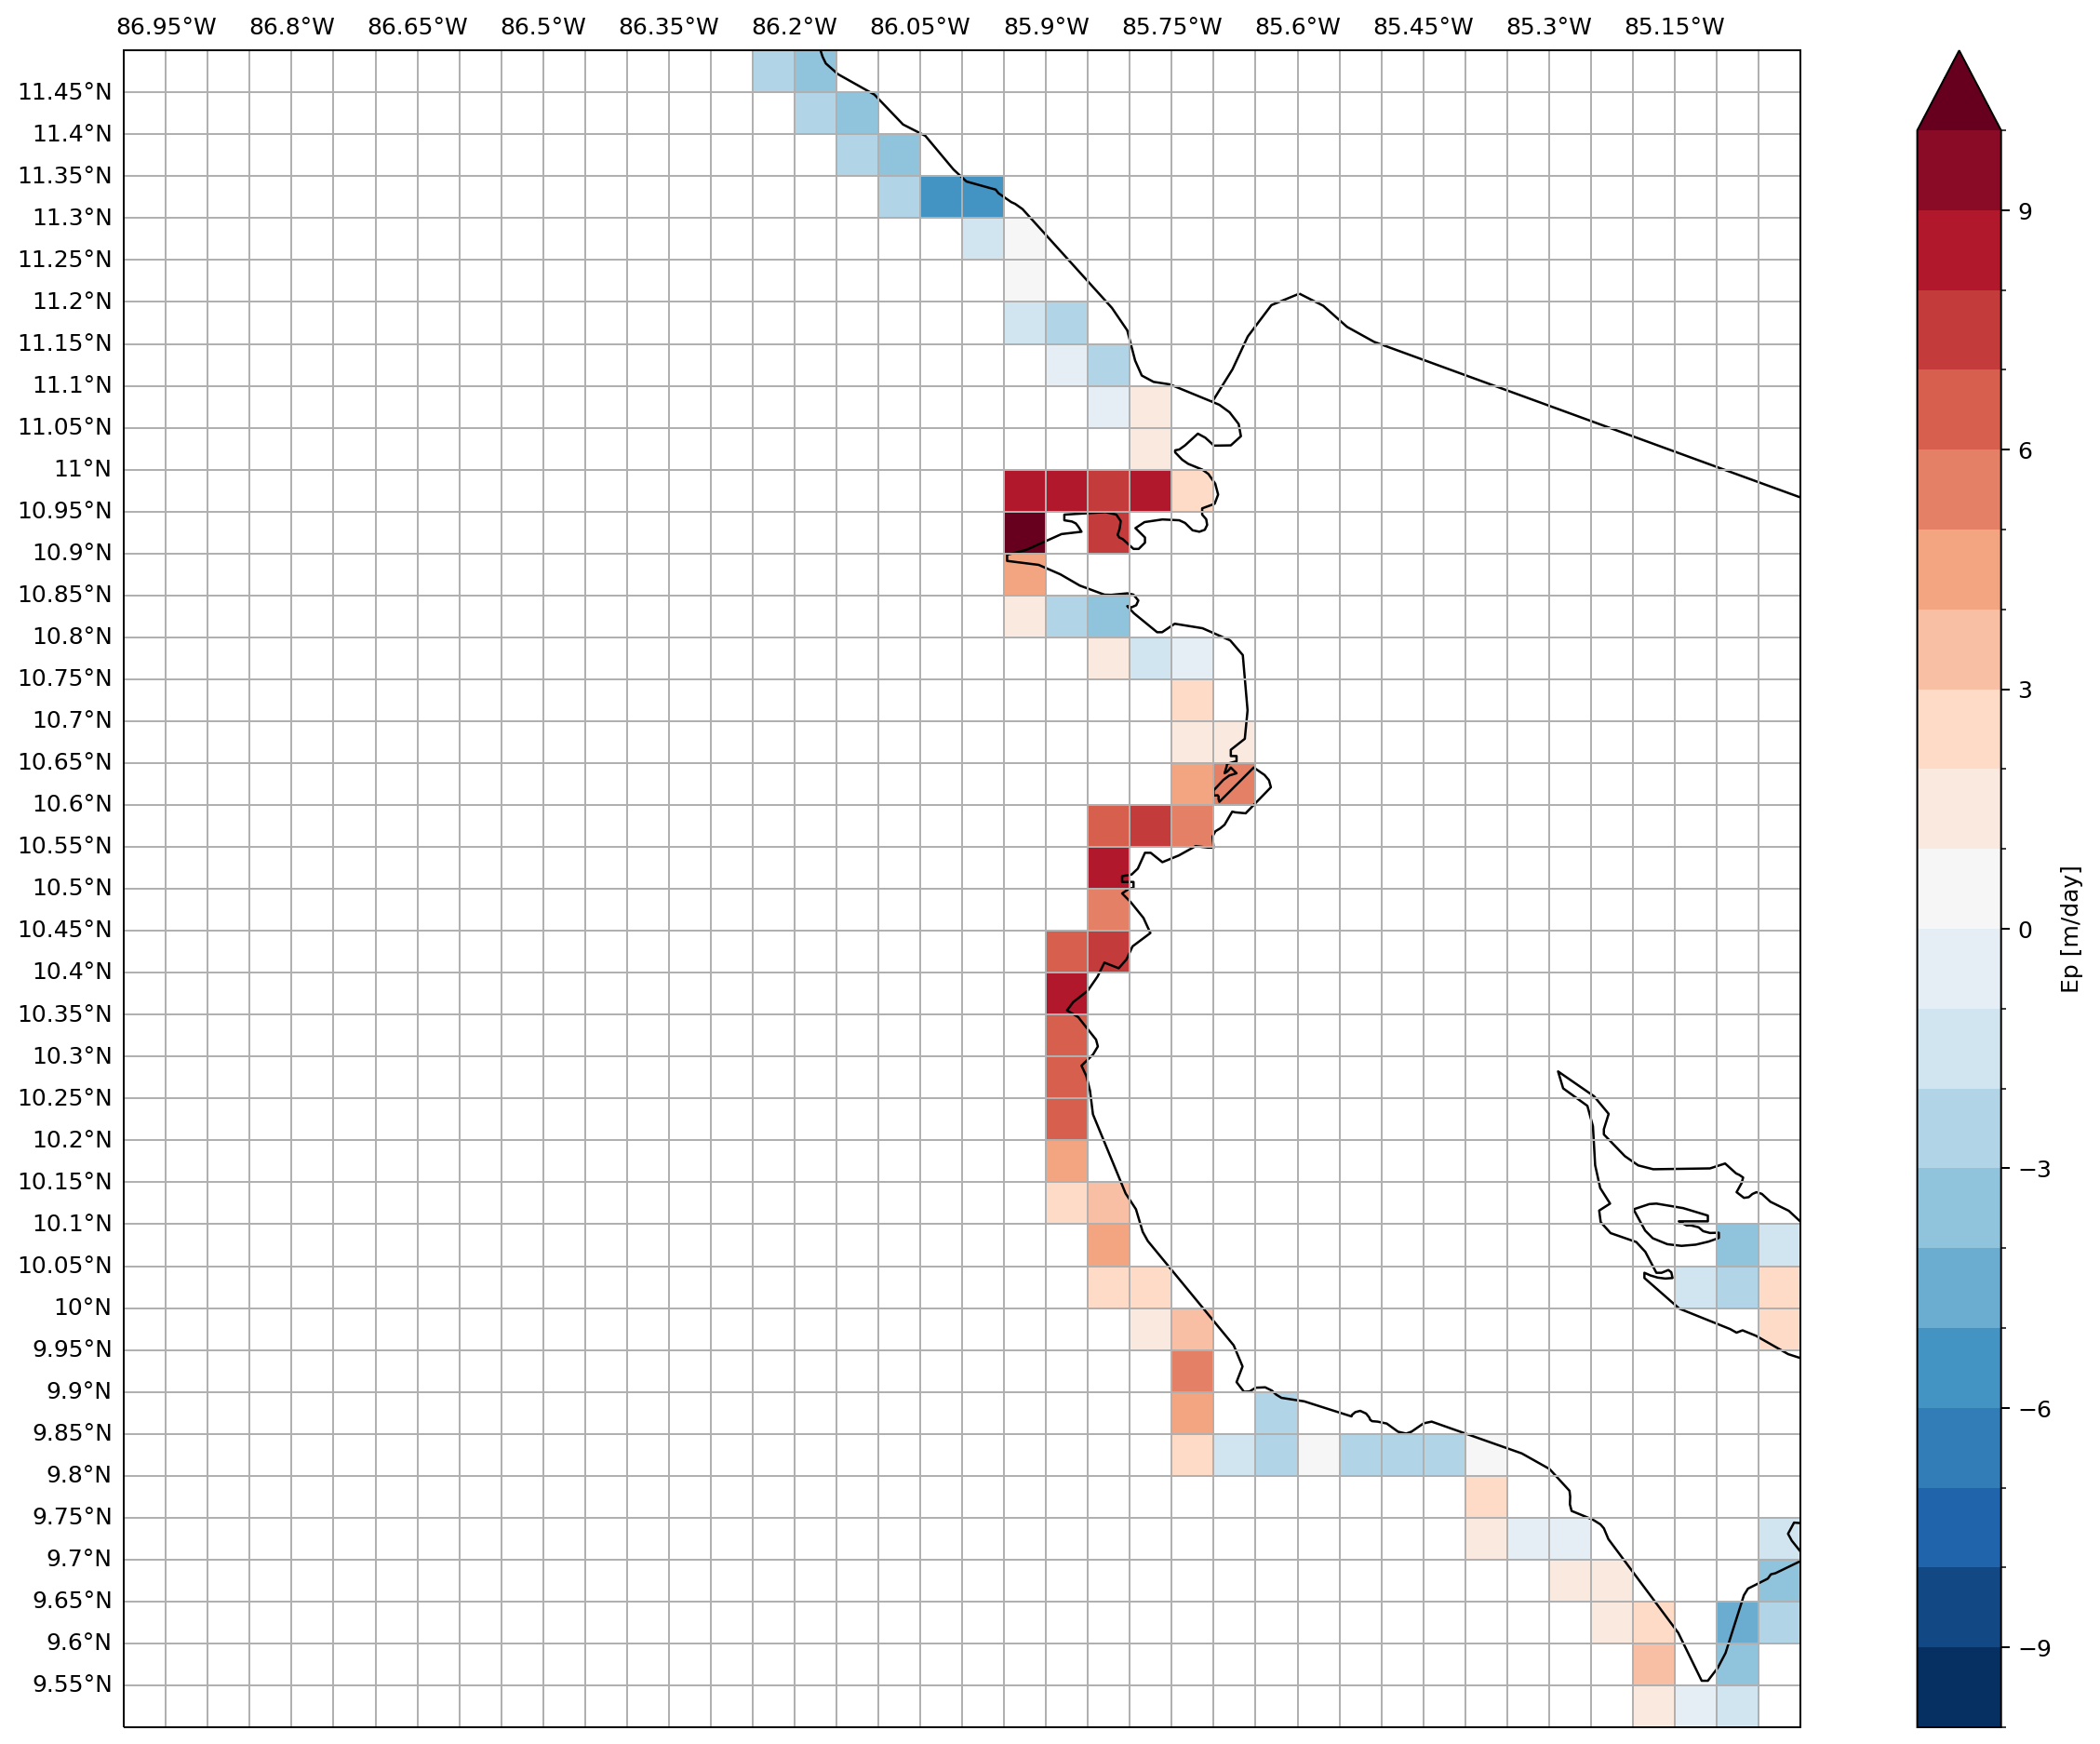

In [18]:
fig=plt.figure(figsize=(18,13))
ax=fig.add_subplot(projection=cr.PlateCarree())
CoastMean.plot(vmin=-20, vmax=20, cmap="RdBu_r", cbar_kwargs={"label": "Ep [m/day]"}, levels=np.arange(-10,11,1))
# vmin=-1.5,vmax=1.5
#annotate_stats(plt.gca(), Ep3[Ep3.month==mes], x=0.3, y=0.4)
#cbar.ax.tick_params(labelsize=10)
ax.coastlines(resolution='10m')
ax.add_feature(cf.BORDERS)
ax.set_extent([-87, -85, 9.5,11.5], crs=cr.PlateCarree())
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines()
gl.xlabels_top = True
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-87,-85,0.05))
gl.ylocator = mticker.FixedLocator(np.arange(9.5,11.5,0.05))

In [19]:
CoastMean.max().values

array(11.4198915)

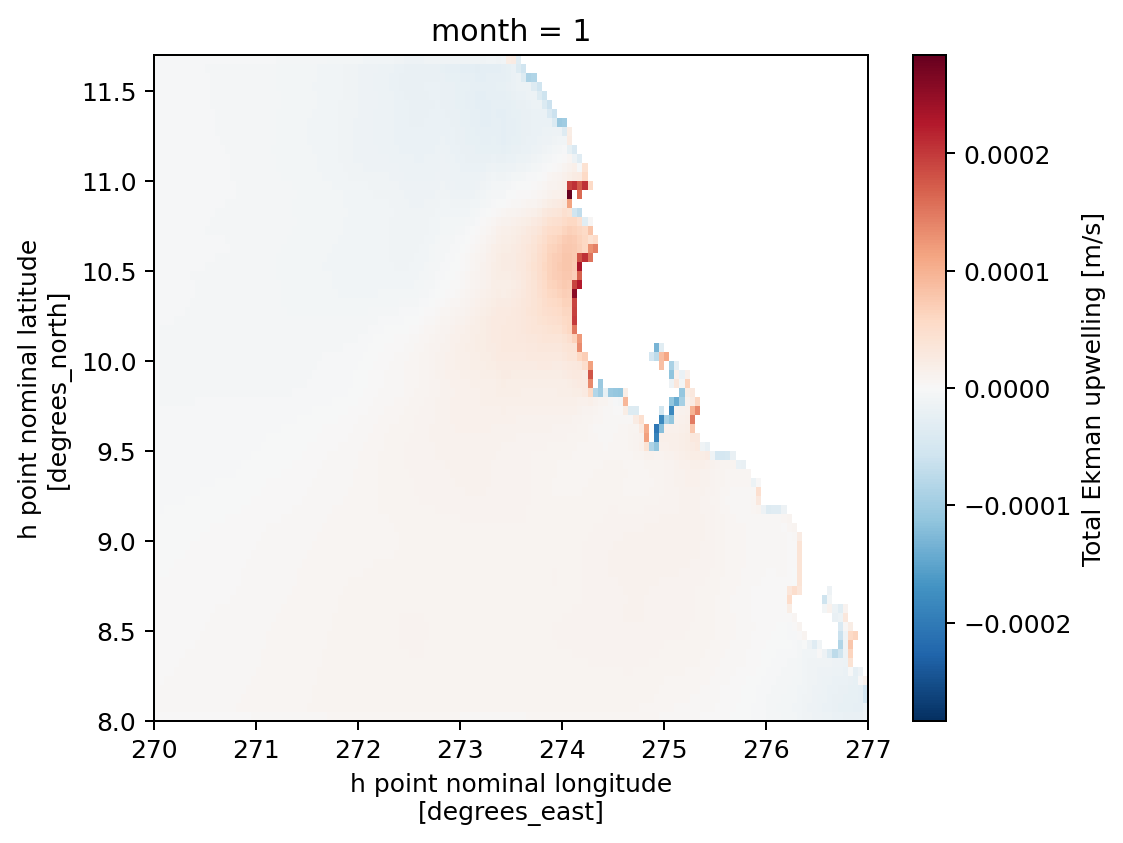

In [20]:
DS1test = DS1.where(DS1['Wek'] != 0.)
DS1test['Wek'][DS1test['Wek'].month==1].plot()

#EPocean[EPocean.month==mes]).plot(cmap="coolwarm", cbar_kwargs={"label": ""})

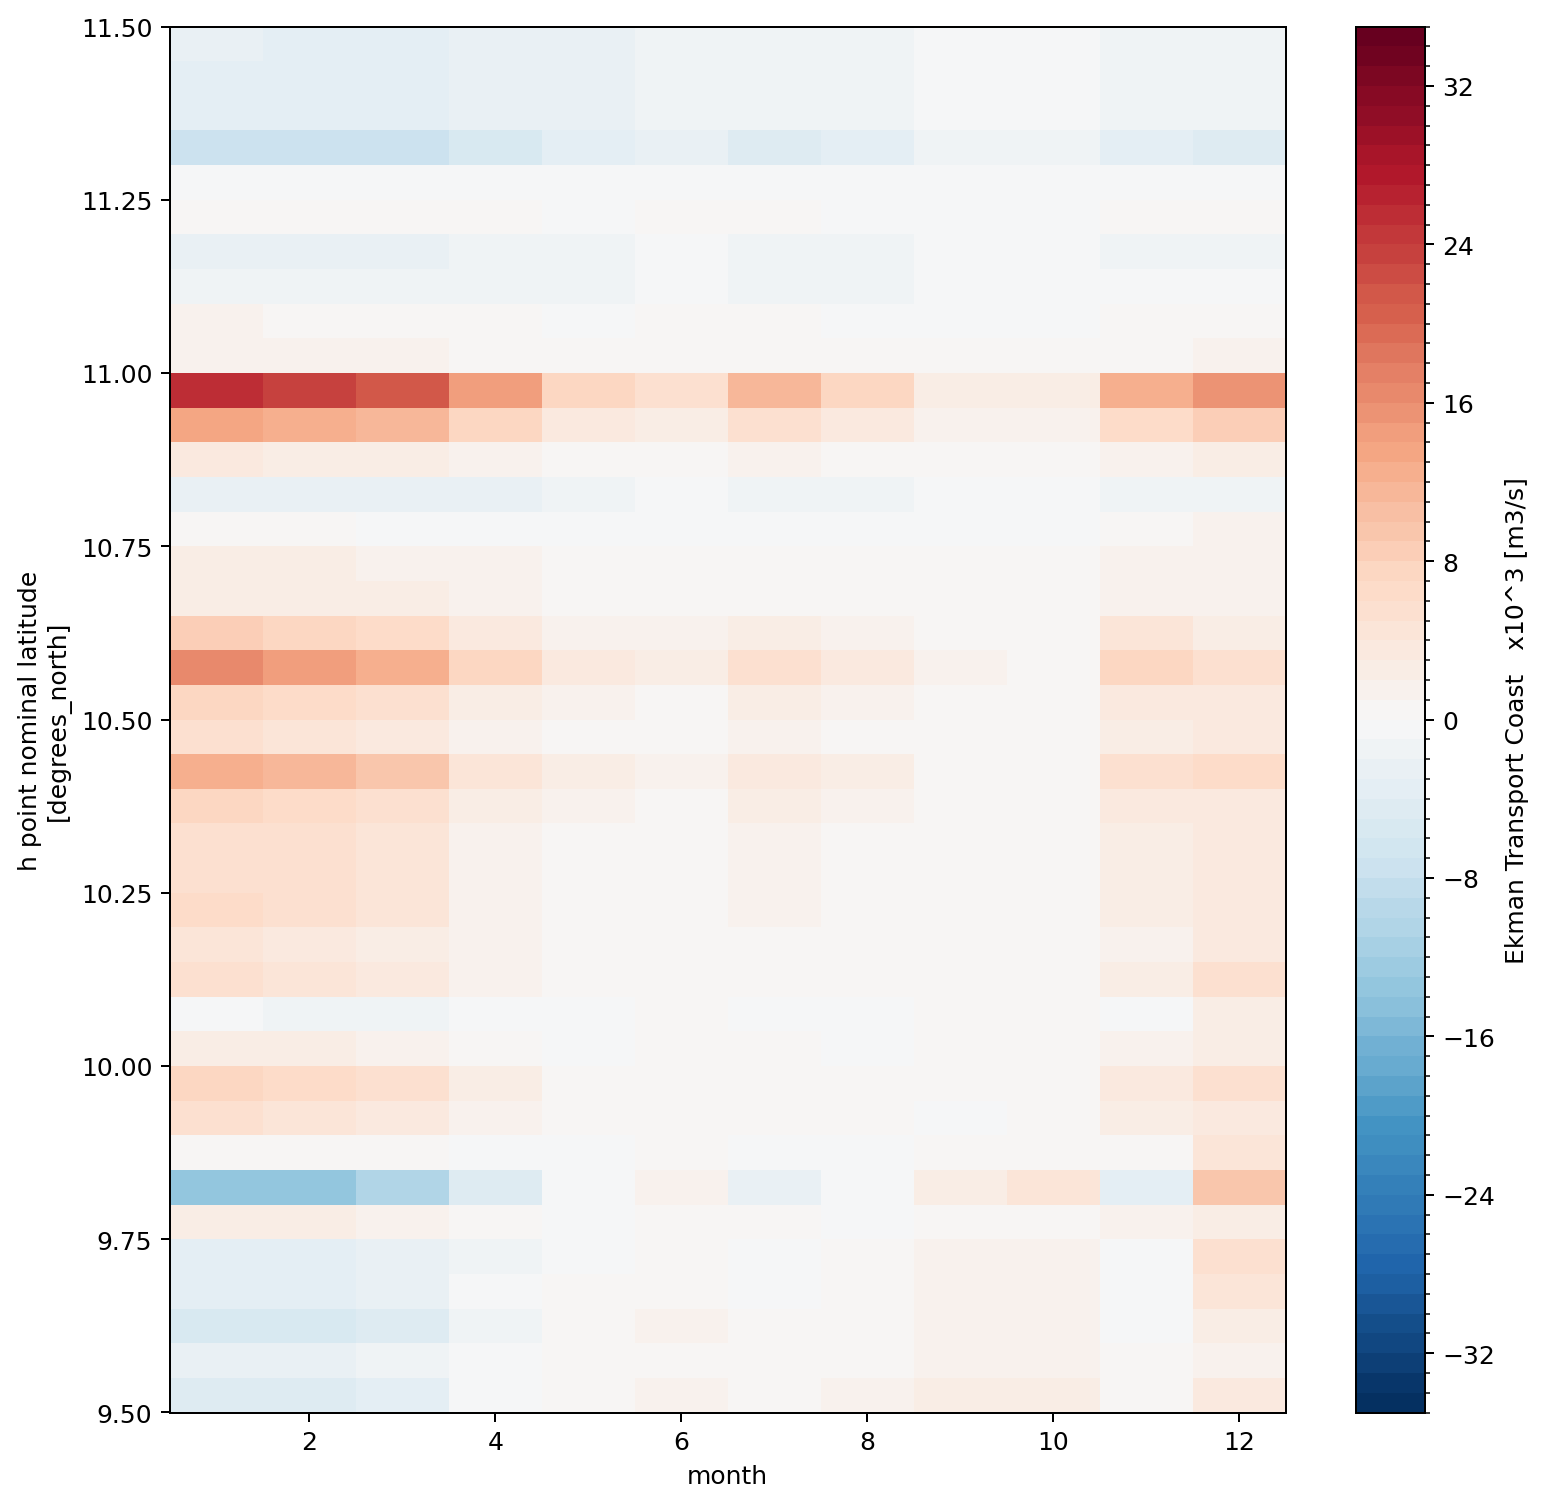

In [42]:
fig=plt.figure(figsize=(10,10))
coast_upwell_T = (Ep2*dsg['Ah']*coast/86400/1000).sel(xh=slice(270,285),yh=slice(9.5,11.5)).sum(dim={'xh'})
coast_upwell_T.T.plot(vmin=-35, vmax=35, levels=np.arange(-35,36,1), cmap="RdBu_r",cbar_kwargs={"label": "Ekman Transport Coast   x10^3 [m3/s]"})
# Transport m3/s

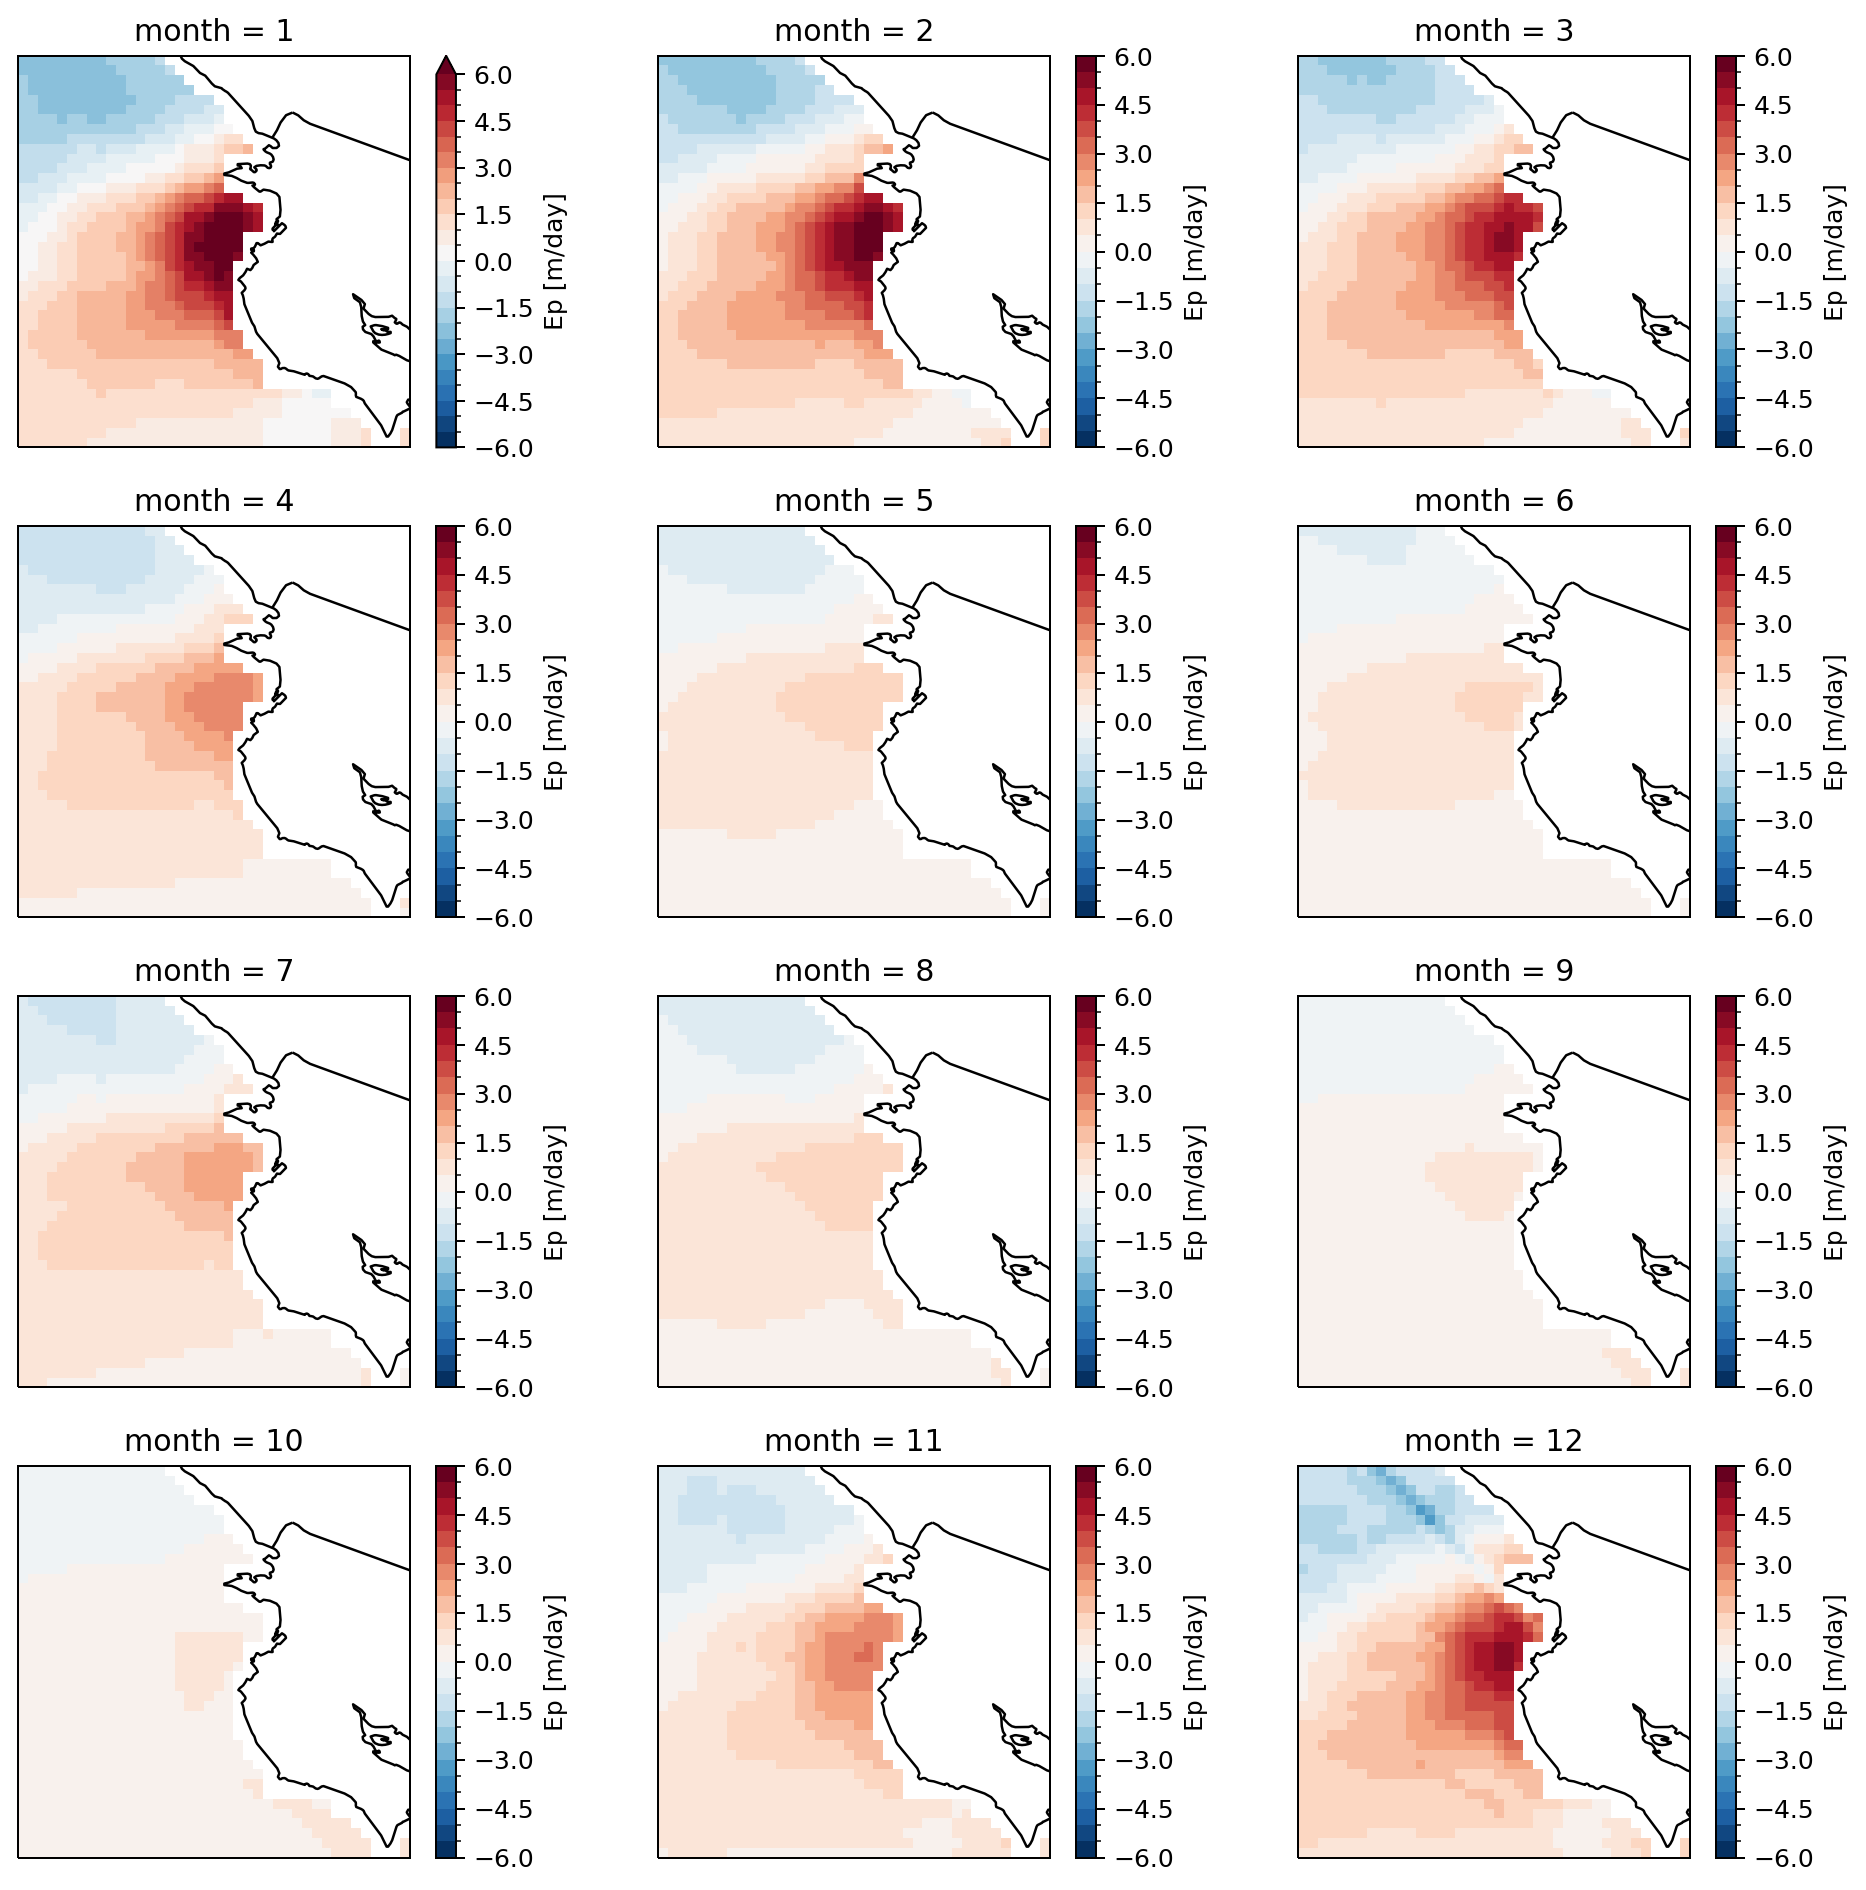

In [22]:
count = 0
fig=plt.figure(figsize=(13,13))
for mes in CoastUp.month:
             count+=1
             ax=fig.add_subplot(4,3,count,projection=cr.PlateCarree())
             #Ep2[Ep2.month==mes].plot(vmin=-4, vmax=4, cmap="coolwarm_r", cbar_kwargs={"label": "w [m/day]"}, levels=np.arange(-4,4.5,0.5))
             (EPocean[EPocean.month==mes]).plot(vmin=-6, vmax=6,cmap="RdBu_r", cbar_kwargs={"label": "Ep [m/day]"}, levels=np.arange(-6,6.5,0.5))
#             annotate_stats(plt.gca(), Ep2[Ep2.month==mes], x=0.3, y=0.4)
             ax.coastlines(resolution='10m')
             ax.add_feature(cf.BORDERS)
             ax.set_extent([-87, -85, 9.5,11.5])

/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
Task exception was never retrieved
future: <Task finished name='Task-225' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/pmo

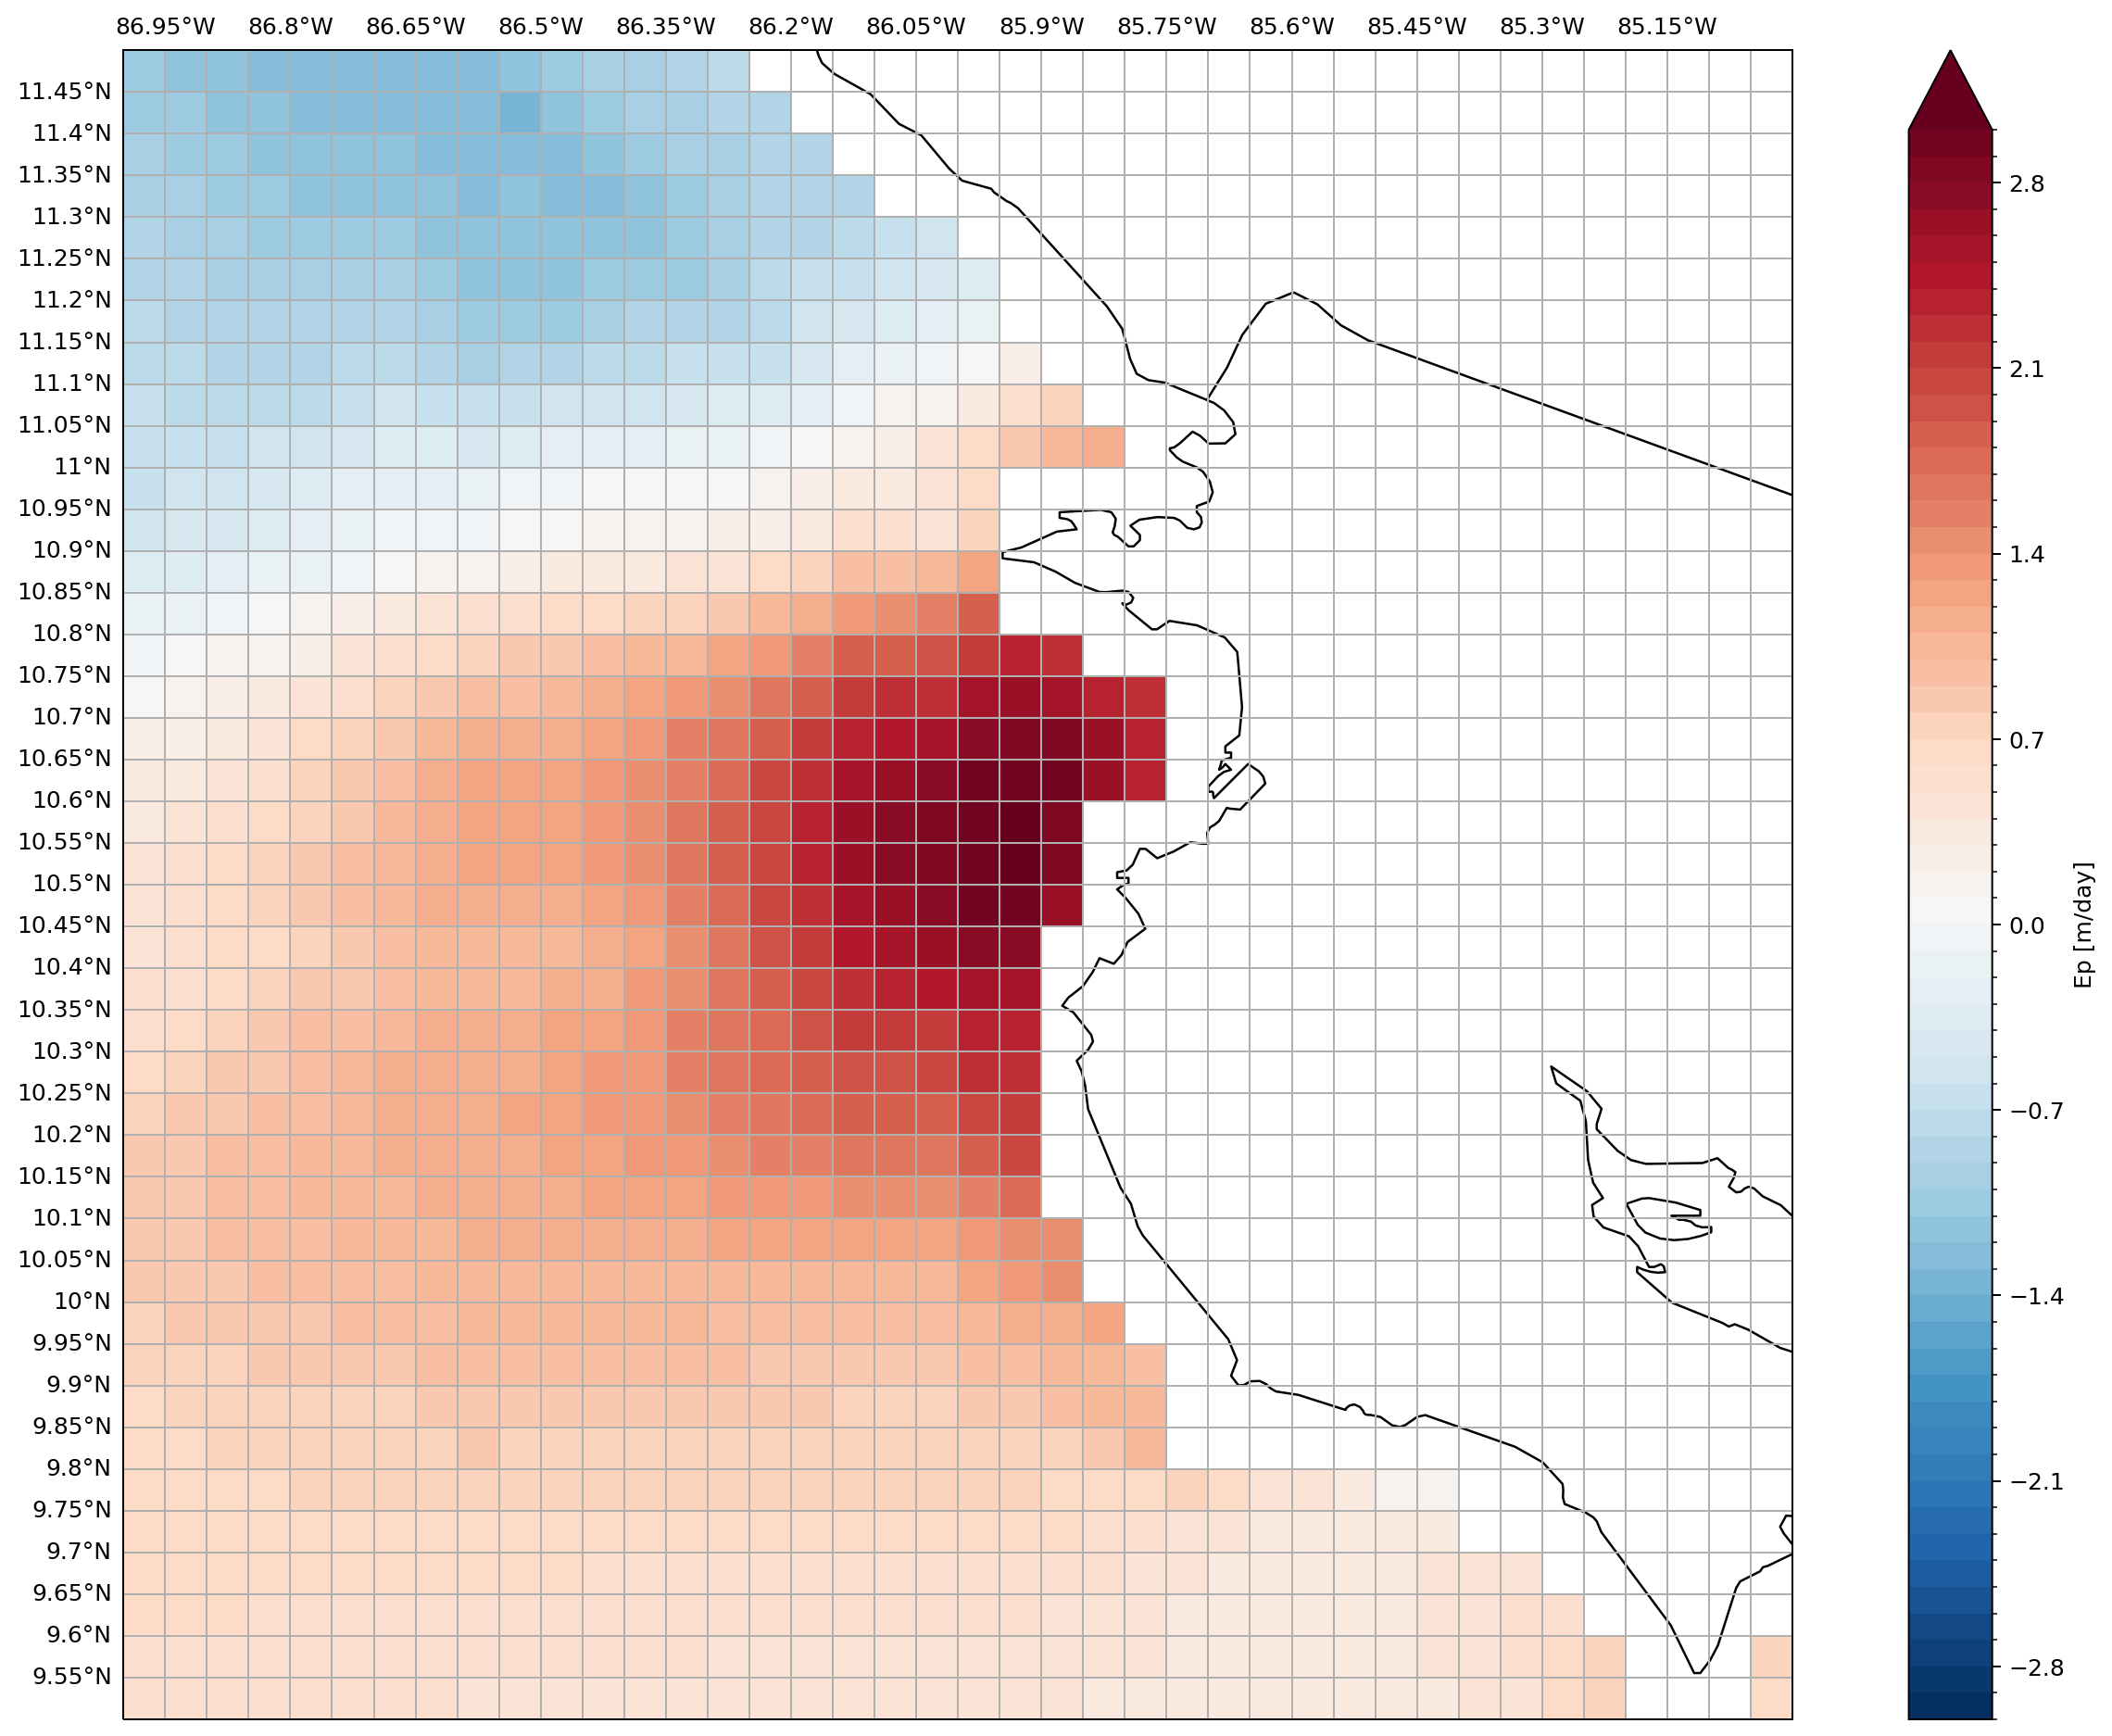

In [34]:
fig=plt.figure(figsize=(18,13))
ax=fig.add_subplot(projection=cr.PlateCarree())
EPoceanMean.plot(vmin=-3, vmax=3,cmap="RdBu_r", cbar_kwargs={"label": "Ep [m/day]"}, levels=np.arange(-3,3.1,0.1))
# vmin=-1.5,vmax=1.5
#annotate_stats(plt.gca(), Ep3[Ep3.month==mes], x=0.3, y=0.4)
ax.coastlines(resolution='10m')
ax.add_feature(cf.BORDERS)
ax.set_extent([-87, -85, 9.5,11.5], crs=cr.PlateCarree())
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines()
gl.xlabels_top = True
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-87,-85,0.05))
gl.ylocator = mticker.FixedLocator(np.arange(9.5,11.5,0.05))

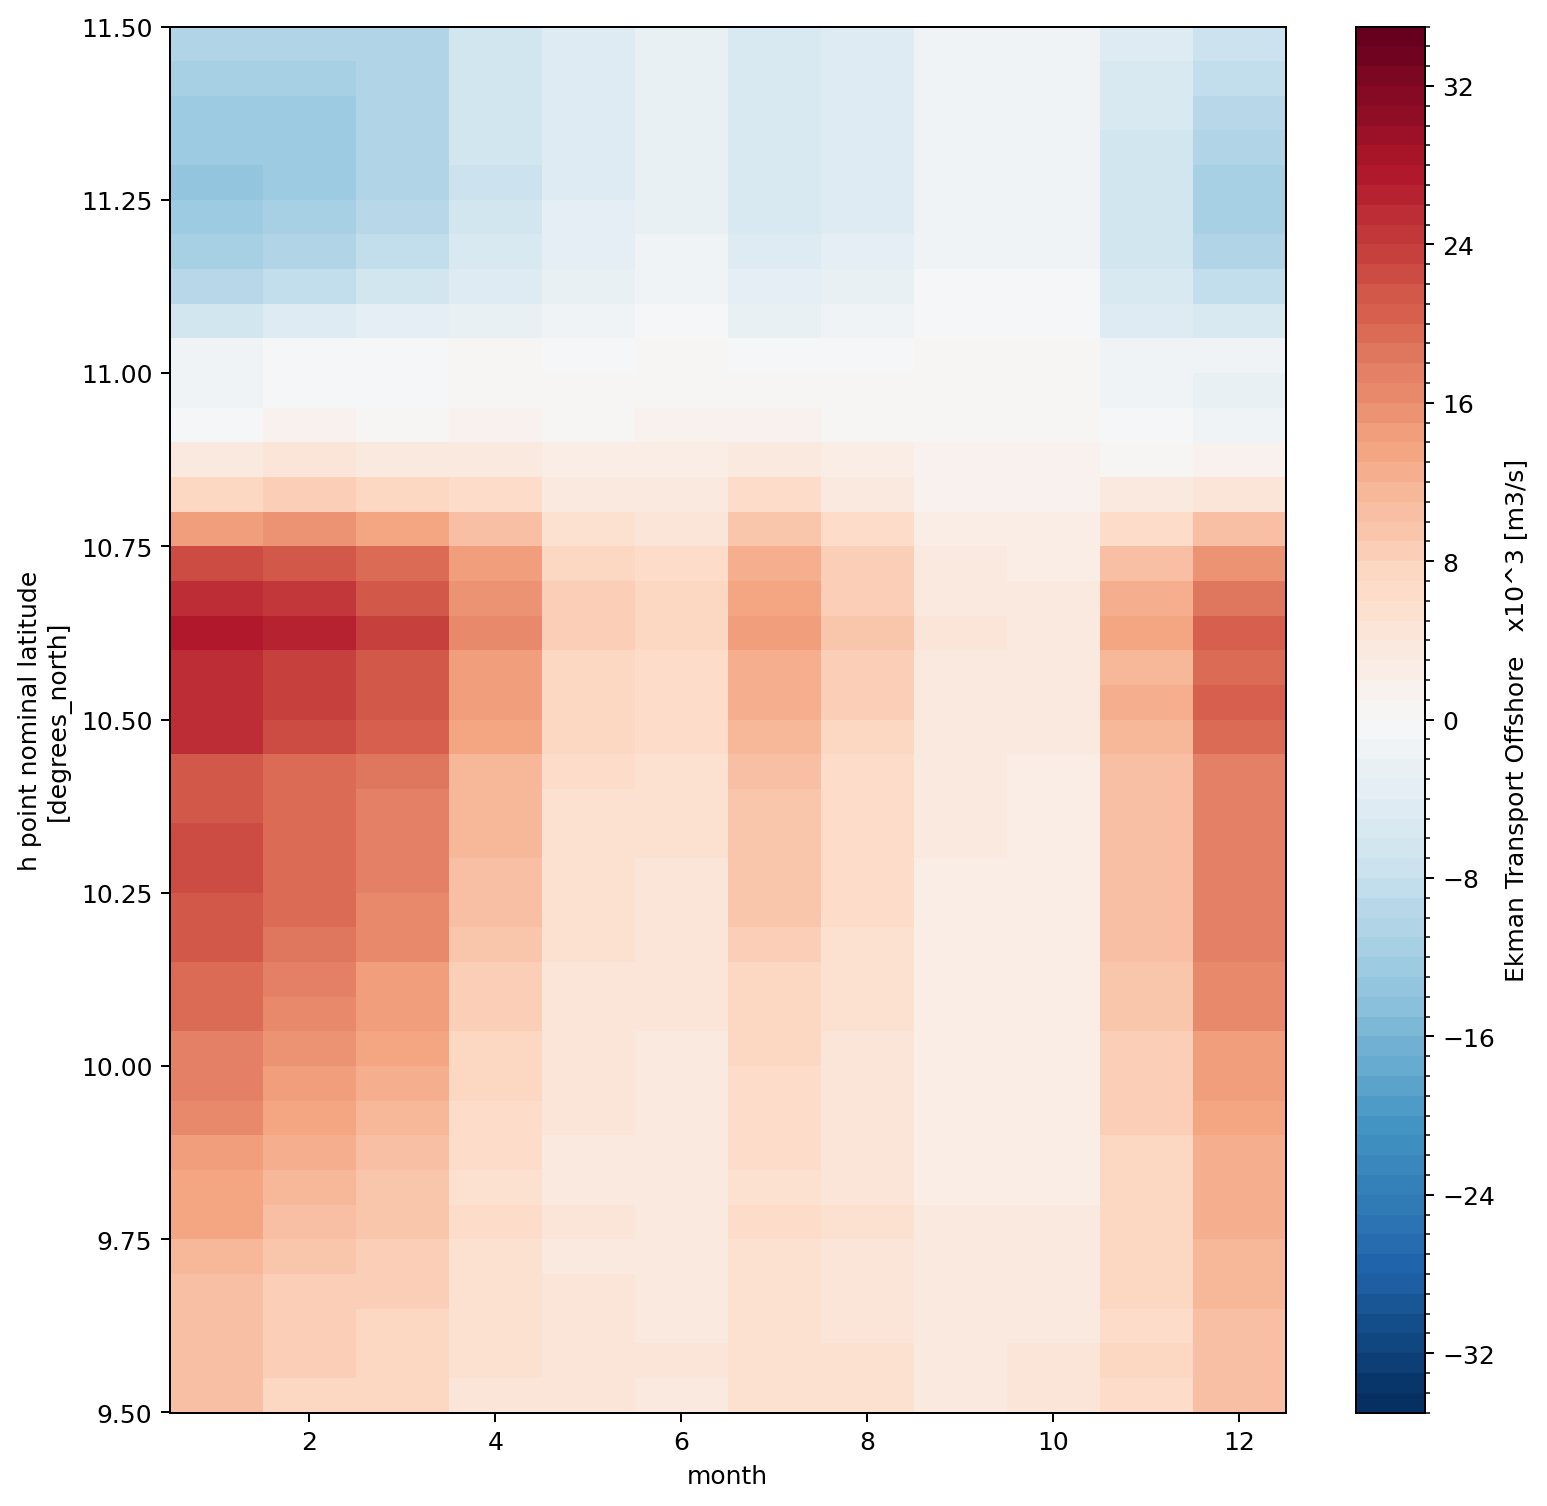

In [43]:
fig=plt.figure(figsize=(10,10))
ocean_upwell_T = (Ep2*dsg['Ah']*ocean/86400/1000).sel(xh=slice(270,285),yh=slice(9.5,11.5)).sum(dim={'xh'})
ocean_upwell_T.T.plot(vmin=-35, vmax=35, levels=np.arange(-35,36,1), cmap="RdBu_r", cbar_kwargs={"label": "Ekman Transport Offshore   x10^3 [m3/s]"})
# Transport m3/s

In [ ]:
client.close()
cluster.close()